# 📥 Step 1: Load and Preprocess Raw Data
This step loads the raw dataset and transforms it into four structured CSV files: `sales.csv`, `products.csv`, `customers.csv`, and `stores.csv`. It also enriches data with `income_segment`, `region`, and `store_size`.

In [23]:
import pandas as pd
import random
import os

try:
    df = pd.read_csv("customer_shopping_data.csv")
except FileNotFoundError:
    raise FileNotFoundError("❌ Error: 'customer_shopping_data.csv' file not found.")
except Exception as e:
    raise Exception(f"❌ Failed to load dataset: {e}")

# 1. sales.csv
sales_df = df[['invoice_no', 'customer_id', 'category', 'quantity', 'price', 'invoice_date', 'shopping_mall']].copy()
sales_df.rename(columns={
    'invoice_no': 'transaction_id',
    'category': 'product_category',
    'invoice_date': 'date',
    'shopping_mall': 'store_id'
}, inplace=True)
sales_df.to_csv("sales.csv", index=False)

# 2. products.csv
products_df = df[['category']].drop_duplicates().copy()
products_df.rename(columns={'category': 'product_category'}, inplace=True)
products_df['product_id'] = ['P' + str(i).zfill(3) for i in range(1, len(products_df) + 1)]
products_df.to_csv("products.csv", index=False)

# 3. customers.csv with income_segment
customers_df = df[['customer_id', 'age', 'gender']].drop_duplicates().copy()
def assign_income(age):
    if age < 25:
        return 'Low'
    elif 25 <= age < 50:
        return 'Medium'
    else:
        return 'High'
customers_df['income_segment'] = customers_df['age'].apply(assign_income)
customers_df.to_csv("customers.csv", index=False)

# 4. stores.csv with region and store_size
stores_df = df[['shopping_mall']].drop_duplicates().copy()
stores_df.rename(columns={'shopping_mall': 'store_id'}, inplace=True)
regions = ['North', 'South', 'East', 'West']
sizes = ['Small', 'Medium', 'Large']
stores_df['region'] = [random.choice(regions) for _ in range(len(stores_df))]
stores_df['store_size'] = [random.choice(sizes) for _ in range(len(stores_df))]
stores_df.to_csv("stores.csv", index=False)


### 📊 Step 2: Import Required Libraries
We use Pandas for data manipulation, Matplotlib for visualization, and Seaborn for enhanced plots.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### 📉 Step 3: Analyze Sales Trends Over Time
Here we calculate monthly revenue and identify percentage changes to observe any decline in sales.

In [25]:
# Load sales data
sales = pd.read_csv("sales.csv")

# Convert date to datetime
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True, errors='coerce')

# Basic stats
print(sales.describe())


           quantity         price                        date
count  99457.000000  99457.000000                       99457
mean       3.003429    689.256321  2022-02-04 02:46:59.783424
min        1.000000      5.230000         2021-01-01 00:00:00
25%        2.000000     45.450000         2021-07-19 00:00:00
50%        3.000000    203.300000         2022-02-05 00:00:00
75%        4.000000   1200.320000         2022-08-22 00:00:00
max        5.000000   5250.000000         2023-03-08 00:00:00
std        1.413025    941.184567                         NaN


### 🔗 Step 4: Merge All Datasets
We join the sales data with customer, store, and product data to generate a unified dataset for deep analysis and Power BI visualization.

In [ ]:
# Load all updated CSVs
sales = pd.read_csv("sales.csv")
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
sales['month'] = sales['date'].dt.to_period('M')
sales['quarter'] = sales['date'].dt.to_period('Q')
sales['revenue'] = sales['price'] * sales['quantity']

# Monthly Revenue Trend
monthly_sales = sales.groupby('month')['revenue'].sum().reset_index()
monthly_sales['pct_change'] = monthly_sales['revenue'].pct_change() * 100

# Plot Monthly Sales
monthly_sales.set_index('month')['revenue'].plot(kind='line', marker='o', title='Monthly Revenue Trend')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

# Merge datasets for deeper analysis
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
stores = pd.read_csv("stores.csv")

merged_df = sales.merge(customers, on='customer_id') \
                 .merge(products, on='product_category') \
                 .merge(stores, on='store_id')
merged_df.to_csv("merged_sales_data.csv", index=False)


In [26]:
print(sales['product_category'].value_counts())

product_category
Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: count, dtype: int64


In [27]:
# Remove unwanted characters from price column (₹, commas, spaces)
sales['price'] = sales['price'].astype(str).str.replace(r'[^\d\.]', '', regex=True)

# Convert cleaned strings to numeric (float), forcing errors to NaN
sales['price'] = pd.to_numeric(sales['price'], errors='coerce')

# Drop rows with missing or invalid prices
sales.dropna(subset=['price'], inplace=True)


In [ ]:
print(sales['price'].dtype)
print(sales['price'].head())


In [14]:
print(monthly_sales.dtypes)
print(monthly_sales.head())


month    period[M]
price      float64
dtype: object
     month       price
0  2021-01  2656422.78
1  2021-02  2358636.34
2  2021-03  2618434.14
3  2021-04  2558825.62
4  2021-05  2662369.93


In [15]:
# Fix price: remove any symbols, convert to float
sales['price'] = sales['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
sales['price'] = pd.to_numeric(sales['price'], errors='coerce')
sales.dropna(subset=['price'], inplace=True)

# Fix date column
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
sales.dropna(subset=['date'], inplace=True)

# Convert date to month string (YYYY-MM) instead of Period
sales['month'] = sales['date'].dt.to_period('M').astype(str)

# Now group again
monthly_sales = sales.groupby('month')['price'].sum().reset_index()

# Validate
print(monthly_sales.dtypes)
print(monthly_sales.head())


month     object
price    float64
dtype: object
     month       price
0  2021-01  2656422.78
1  2021-02  2358636.34
2  2021-03  2618434.14
3  2021-04  2558825.62
4  2021-05  2662369.93


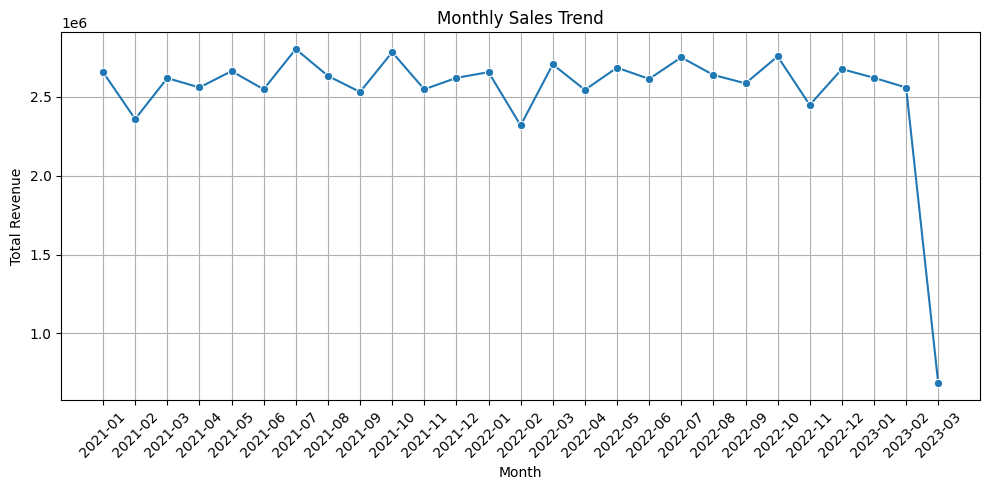

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='month', y='price', marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


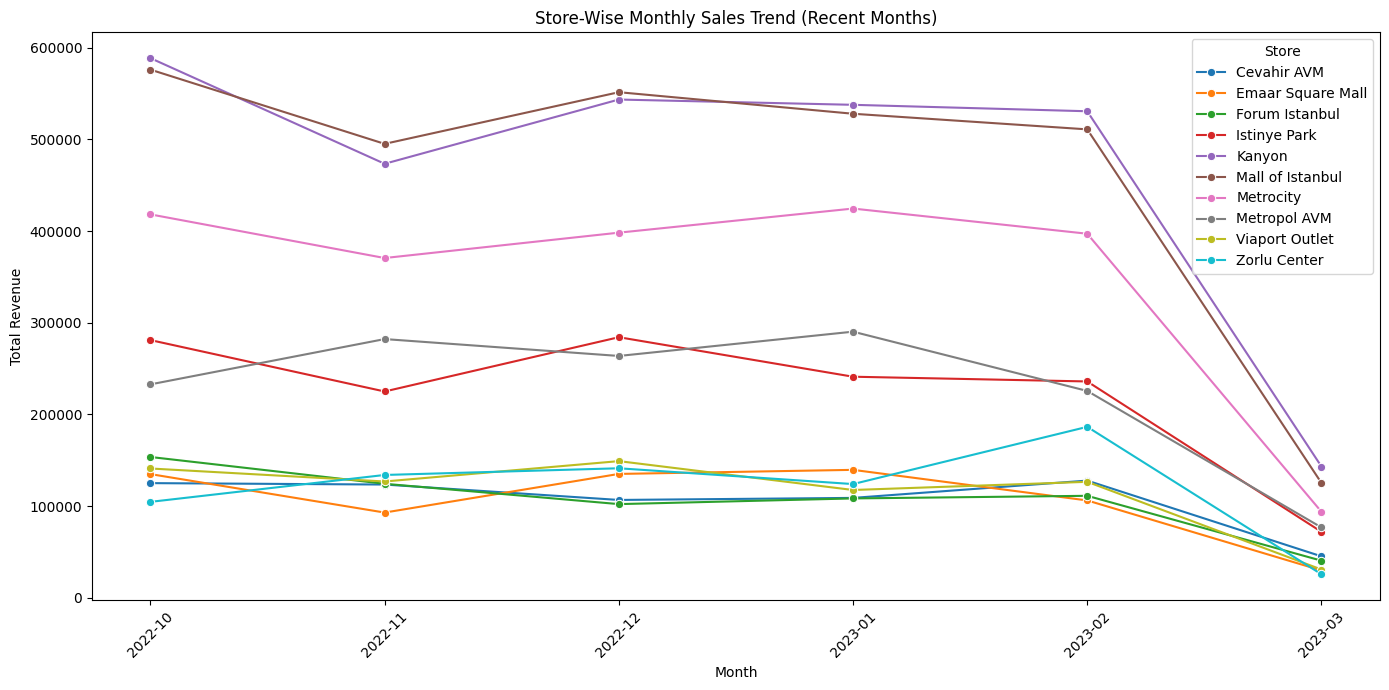

In [17]:
# Group by store and month
store_monthly_sales = sales.groupby(['store_id', 'month'])['price'].sum().reset_index()

# Filter for recent months (optional, to focus on 2023)
store_monthly_sales = store_monthly_sales[store_monthly_sales['month'] >= '2022-10']

# Plot each store
plt.figure(figsize=(14, 7))
sns.lineplot(data=store_monthly_sales, x='month', y='price', hue='store_id', marker='o')
plt.title("Store-Wise Monthly Sales Trend (Recent Months)")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.legend(title='Store')
plt.tight_layout()
plt.show()


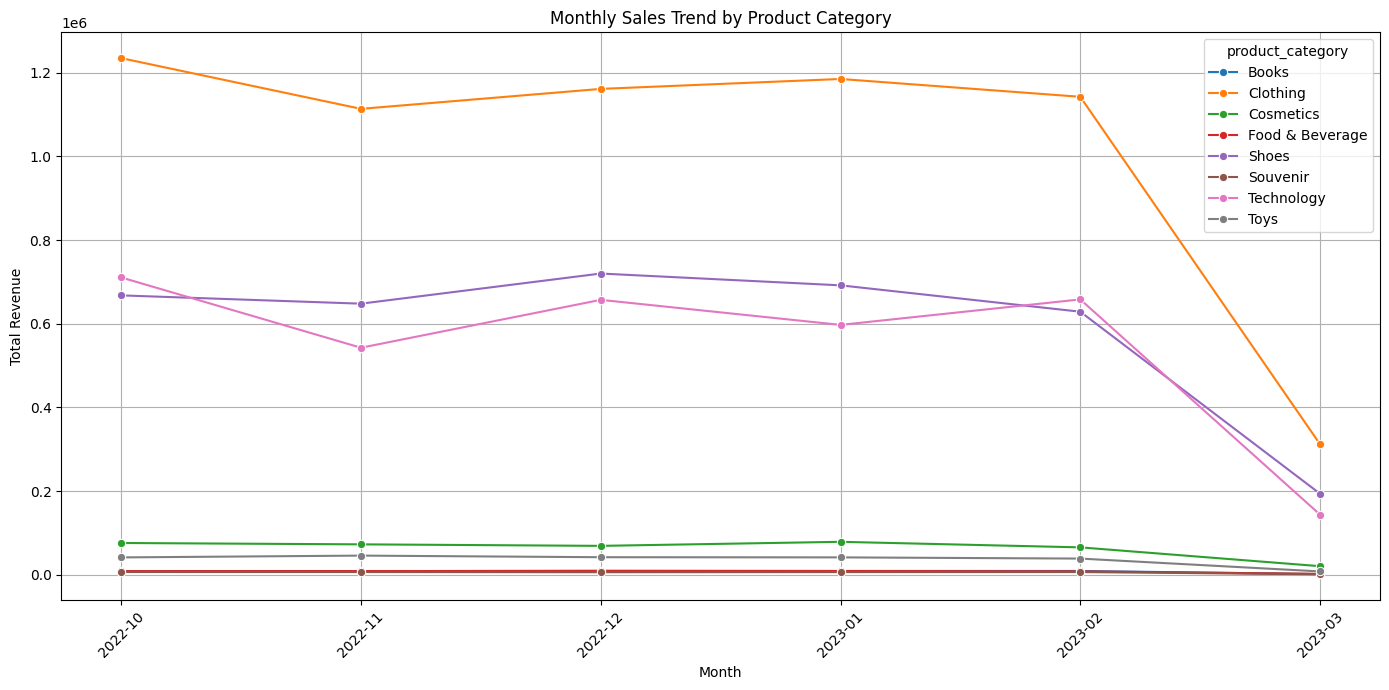

In [20]:
# Group by month and product category
category_trend = sales.groupby(['month', 'product_category'])['price'].sum().reset_index()

# Filter to recent months only
category_trend = category_trend[category_trend['month'] >= '2022-10']

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=category_trend, x='month', y='price', hue='product_category', marker='o')
plt.title("Monthly Sales Trend by Product Category")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


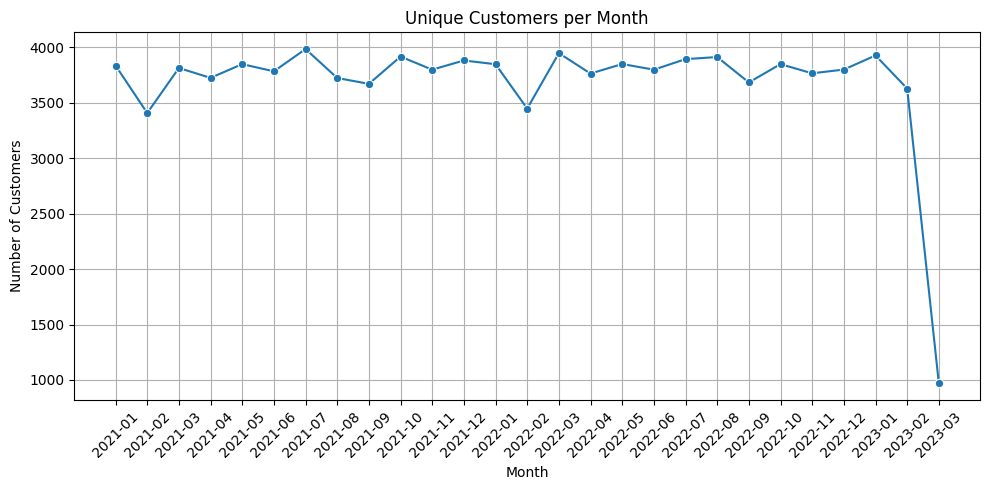

In [21]:
# Number of unique customers each month
monthly_customers = sales.groupby('month')['customer_id'].nunique().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_customers, x='month', y='customer_id', marker='o')
plt.title("Unique Customers per Month")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Save overall sales
sales.to_csv("sales.csv", index=False)

# Create monthly sales
monthly_sales = sales.groupby('month')['price'].sum().reset_index()
monthly_sales.to_csv("monthly_sales.csv", index=False)

# Store-wise sales
store_sales = sales.groupby(['month', 'store_id'])['price'].sum().reset_index()
store_sales.to_csv("store_sales.csv", index=False)

# Product category trend
category_sales = sales.groupby(['month', 'product_category'])['price'].sum().reset_index()
category_sales.to_csv("category_sales.csv", index=False)

# Monthly customer count
monthly_customers = sales.groupby('month')['customer_id'].nunique().reset_index()
monthly_customers.to_csv("monthly_customers.csv", index=False)
